In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading all necessary packages
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import numpy as np
import scipy.misc

from PIL import Image

import keras
import keras.callbacks
import keras.backend as K
from keras import optimizers
from keras.engine.topology import Layer
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Concatenate, Lambda, Conv2D, MaxPooling2D, Flatten, Multiply

from keras.models import Model
from collections import OrderedDict
from tqdm import trange, tqdm

import tensorflow as tf
from tensorflow import image as tfi

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
'''
Preprocessing function for images and fixation maps

inputs:
-img_path: A string containing path of the image to be pre-processes
-image_size: A tuple of form (width, height) of image
-space: strign specifying whether image has 'rgb' space or 'gray' space

Returns:
-x: numpy array with preprocessed pixed values of the image
'''
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x[0]
    elif space=='gray':
        img = image.load_img(img_path, target_size=image_size, grayscale=True)
        x = image.img_to_array(img)
        x /= 255.
        return x

In [ ]:

class MySigmoidLayer(Layer):
    def __init__(self, **kwargs):
        super(MySigmoidLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, 1),
                                      initializer='uniform',
                                      trainable=True)
        super(MySigmoidLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return 1./(1.+K.exp(-(x-0.5)*self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape
    

In [ ]:
'''
Create model with the above defined architecture and compile it with necessary parameters
and prints the model summary

Input: None

Output:
- model: The compiled model
'''
def create_weighted_model():
    vgg16_1 = VGG16(include_top=False, weights='imagenet', input_shape=(600, 800, 3))
    vgg16_2 = VGG16(include_top=False, weights='imagenet', input_shape=(300, 400, 3))
    for layer in vgg16_2.layers:
        layer._name = layer.name + "_sec"

    vgg16_2_output = Lambda(lambda x_: tf.image.resize(x_, (18, 25)),name="lambda_c1")(vgg16_2.get_layer("block5_pool_sec").output)
    x = Concatenate(name="my_concat")([vgg16_1.get_layer("block5_pool").output, vgg16_2_output])
    x = Lambda(lambda x_: tf.divide(x_, 255.), name="lambda_concate")(x)
    
    #Missing subnetwork layers from CASnet architecture

    sal_output = Conv2D(1, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(x)
    sal_output = MySigmoidLayer()(sal_output)
    
    new_model = Model(inputs=[vgg16_1.input, vgg16_2.input], outputs=sal_output)

    
    return new_model

In [ ]:

model = create_weighted_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4_sec (InputLayer)        [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_sec (Conv2D)       (None, 300, 400, 64) 1792        input_4_sec[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_3[0][0]                    
_______________________________________________________________________________________

  0%|          | 0/10 [00:00<?, ?it/s]

0001.jpg


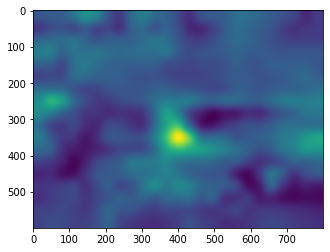

 10%|█         | 1/10 [00:06<00:55,  6.11s/it]

0002.jpg


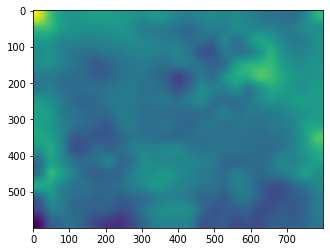

 20%|██        | 2/10 [00:12<00:50,  6.25s/it]

0003.jpg


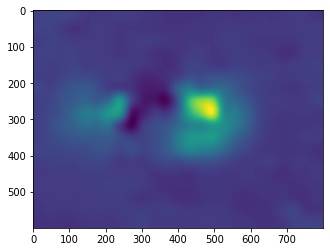

 30%|███       | 3/10 [00:19<00:44,  6.33s/it]

0004.jpg


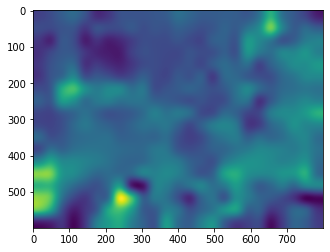

 40%|████      | 4/10 [00:25<00:38,  6.36s/it]

0005.jpg


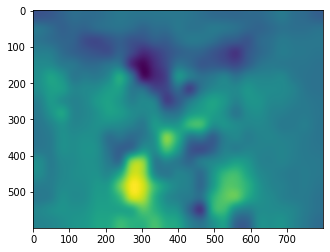

 50%|█████     | 5/10 [00:32<00:32,  6.41s/it]

0006.jpg


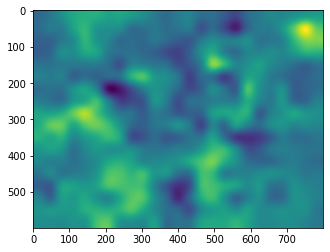

 60%|██████    | 6/10 [00:38<00:25,  6.43s/it]

0007.jpg


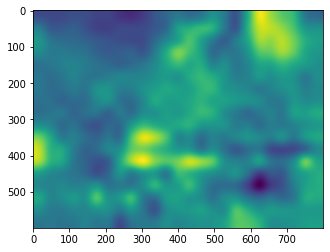

 70%|███████   | 7/10 [00:45<00:19,  6.49s/it]

0008.jpg


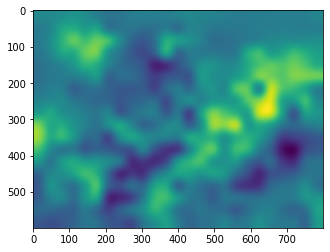

 80%|████████  | 8/10 [00:51<00:13,  6.50s/it]

0009.jpg


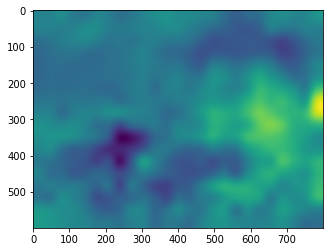

 90%|█████████ | 9/10 [00:58<00:06,  6.49s/it]

0010.jpg


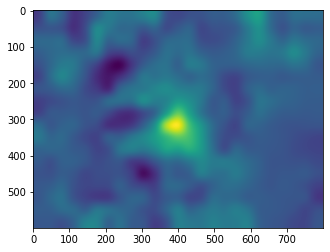

100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


In [ ]:
'''
This function predicts and plots the saliency maps for the Images.
It loads the weights for the layers required for NCASnet to the 
keras Model defined above and plots saliency maps of size (800, 600), 
and saves them into the mentioned folder

input: None
Output: None
'''

def gen_sal_maps()
    images = sorted(glob.glob('/content/drive/My Drive/NNFL Project/Dataset/Unzipped/EMOdImages1019/*.jpg'))[0:10]
    model.load_weights("/content/drive/My Drive/NNFL Project/Dataset/salicon_generator_sigmoid_epoch_25.h5", by_name = True)

    for ind, img,in enumerate(tqdm(images)):
        name = os.path.basename(img)
        print(name)
        x1 = np.expand_dims(get_image_data(img, (600, 800), space="rgb"), axis=0)
        x2 = np.expand_dims(get_image_data(img, (300, 400), space="rgb"), axis=0)
        #Predict saliency map by sending input to the model as an
        #array of inputs to two VGG streams
        res = model.predict([x1, x2])

        sal = np.array(Image.fromarray(res[0,:,:,0]).resize((800, 600)))
        # m = Image.fromarray((res[0,:,:,0]).astype(np.uint8)).resize((800, 600))
        # m.save("/content/drive/My Drive/NNFL Project/Dataset/Unzipped/PredSalMaps_Ncasnet/"+name)
        plt.imshow(sal)
        plt.show()

gen_sal_maps()